In [2]:
from sys import builtin_module_names
import imageio
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
from skimage import color
from os import path
from skimage import data
from skimage.filters import meijering, sato, frangi, hessian
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank
#imports 
import AnalysisFuncs as AF
import copy
import csv
import cv2
import importlib
import math
import numpy as np
import os
import pandas as pd
import random
import re
import subprocess
import sys
import threading
import time
import timeit
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.wcs import WCS
from glob import glob
from matplotlib.colors import Normalize
from photutils.background import Background2D, MedianBackground
from reproject import reproject_exact
from scipy.ndimage import gaussian_filter, zoom
from scipy.stats import kde, lognorm
from skimage import measure
from skimage.morphology import skeletonize
import imageio
from astropy.table import Table
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
from skimage import color
from os import path
from skimage import data
from skimage.filters import meijering, sato, frangi, hessian
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank
import skimage


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Copyright 2012 - 2013
# Matías Herranz <matiasherranz@gmail.com>
# Joaquín Tita <joaquintita@gmail.com>
#
# https://github.com/PyRadar/pyradar
#
# This library is free software; you can redistribute it and/or
# modify it under the terms of the GNU Lesser General Public
# License as published by the Free Software Foundation; either
# version 3 of the License, or (at your option) any later version.
#
# This library is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
# Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public
# License along with this library. If not, see <http://www.gnu.org/licenses/>.


import numpy as np
from scipy.cluster import vq

#from pyradar.utils import take_snapshot


def initialize_parameters(parameters=None):
    """Auxiliar function to set default values to all the parameters not
    given a value by the user.

    """
    parameters = {} if not parameters else parameters

    def safe_pull_value(parameters, key, default):
        return parameters.get(key, default)

    # number of clusters desired
    K = safe_pull_value(parameters, 'K', 2)

    # maximum number of iterations
    I = safe_pull_value(parameters, 'I', 100)

    # maximum of number of pairs of clusters which can be merged
    P = safe_pull_value(parameters, 'P', 4)

    # threshold value for  minimum number of samples in each cluster
    # (discarding clusters)
    THETA_M = safe_pull_value(parameters, 'THETA_M', 10)

    # threshold value for standard deviation (for split)
    THETA_S = safe_pull_value(parameters, 'THETA_S', 1)
    # threshold value for pairwise distances (for merge)
    THETA_C = safe_pull_value(parameters, 'THETA_C', 20)

    # percentage of change in clusters between each iteration
    #(to stop algorithm)
    THETA_O = 0.05

    #can use any of both fixed or random
    # number of starting clusters
    #k = np.random.randint(1, K)
    k = safe_pull_value(parameters, 'k', K)

    ret = locals()
    ret.pop('safe_pull_value')
    ret.pop('parameters')
    globals().update(ret)


def quit_low_change_in_clusters(centers, last_centers, iter):
    """Stop algorithm by low change in the clusters values between each
    iteration.

    :returns: True if should stop, otherwise False.

    """
    quit = False
    if centers.shape == last_centers.shape:
        thresholds = np.abs((centers - last_centers) / (last_centers + 1))

        if np.all(thresholds <= THETA_O):  # percent of change in [0:1]
            quit = True
#            print "Isodata(info): Stopped by low threshold at the centers."
#            print "Iteration step: %s" % iter

    return quit


def merge_clusters(img_class_flat, centers, clusters_list):
    """
    Merge by pair of clusters in 'below_threshold' to form new clusters.
    """
    pair_dists = compute_pairwise_distances(centers)

    first_p_elements = pair_dists[:P]

    below_threshold = [(c1, c2) for d, (c1, c2) in first_p_elements
                                if d < THETA_C]

    if below_threshold:
        k = centers.size
        count_per_cluster = np.zeros(k)
        to_add = np.array([])  # new clusters to add
        to_delete = np.array([])  # clusters to delete

        for cluster in range(0, k):
            result = np.where(img_class_flat == clusters_list[cluster])
            indices = result[0]
            count_per_cluster[cluster] = indices.size

        for c1, c2 in below_threshold:
            c1_count = float(count_per_cluster[c1]) + 1
            c2_count = float(count_per_cluster[c2])
            factor = 1.0 / (c1_count + c2_count)
            weight_c1 = c1_count * centers[c1]
            weight_c2 = c2_count * centers[c2]

            value = round(factor * (weight_c1 + weight_c2))

            to_add = np.append(to_add, value)
            to_delete = np.append(to_delete, [c1, c2])

        #delete old clusters and their indices from the availables array
        centers = np.delete(centers, to_delete)
        clusters_list = np.delete(clusters_list, to_delete)

        #generate new indices for the new clusters
        #starting from the max index 'to_add.size' times
        start = int(clusters_list.max())
        end = to_add.size + start

        centers = np.append(centers, to_add)
        clusters_list = np.append(clusters_list, range(start, end))

        centers, clusters_list = sort_arrays_by_first(centers, clusters_list)

    return centers, clusters_list


def compute_pairwise_distances(centers):
    """
    Compute the pairwise distances 'pair_dists', between every two clusters
    centers and returns them sorted.
    Returns:
           - a list with tuples, where every tuple has in it's first coord the
             distance between to clusters, and in the second coord has a tuple,
             with the numbers of the clusters measured.
             Output example:
                [(d1,(cluster_1,cluster_2)),
                 (d2,(cluster_3,cluster_4)),
                 ...
                 (dn, (cluster_n,cluster_n+1))]
    """
    pair_dists = []
    size = centers.size

    for i in range(0, size):
        for j in range(0, size):
            if i > j:
                d = np.abs(centers[i] - centers[j])
                pair_dists.append((d, (i, j)))

    #return it sorted on the first elem
    return sorted(pair_dists)


def split_clusters(img_flat, img_class_flat, centers, clusters_list):
    """
    Split clusters to form new clusters.
    """
    assert centers.size == clusters_list.size, \
        "ERROR: split() centers and clusters_list size are different"

    delta = 10
    k = centers.size
    count_per_cluster = np.zeros(k)
    stddev = np.array([])

    avg_dists_to_clusters = compute_avg_distance(img_flat, img_class_flat,
                                                 centers, clusters_list)
    d = compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                                 clusters_list)

    # compute all the standard deviation of the clusters
    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size
        value = ((img_flat[indices] - centers[cluster]) ** 2).sum()
        value /= count_per_cluster[cluster]
        value = np.sqrt(value)
        stddev = np.append(stddev, value)

    cluster = stddev.argmax()
    max_stddev = stddev[cluster]
    max_clusters_list = int(clusters_list.max())

    if max_stddev > THETA_S:
        if avg_dists_to_clusters[cluster] >= d:
            if count_per_cluster[cluster] > (2.0 * THETA_M):
                old_cluster = centers[cluster]
                new_cluster_1 = old_cluster + delta
                new_cluster_2 = old_cluster - delta

                centers = np.delete(centers, cluster)
                clusters_list = np.delete(clusters_list, cluster)

                centers = np.append(centers, [new_cluster_1, new_cluster_2])
                clusters_list = np.append(clusters_list, [max_clusters_list,
                                          (max_clusters_list + 1)])

                centers, clusters_list = sort_arrays_by_first(centers,
                                                              clusters_list)

                assert centers.size == clusters_list.size, \
                   "ERROR: split() centers and clusters_list size are different"

    return centers, clusters_list


def compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                             clusters_list):
    """
    Computes the overall distance of the samples from their respective cluster
    centers.
    """
    k = avg_dists_to_clusters.size
    total = img_class_flat.size
    count_per_cluster = np.zeros(k)

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size

    d = ((count_per_cluster / total) * avg_dists_to_clusters).sum()

    return d


def compute_avg_distance(img_flat, img_class_flat, centers, clusters_list):
    """
    Computes all the average distances to the center in each cluster.
    """
    k = centers.size
    avg_dists_to_clusters = np.array([])

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]

        total_per_cluster = indices.size + 1
        sum_per_cluster = (np.abs(img_flat[indices] - centers[cluster])).sum()

        dj = (sum_per_cluster / float(total_per_cluster))

        avg_dists_to_clusters = np.append(avg_dists_to_clusters, dj)

    return avg_dists_to_clusters


def discard_clusters(img_class_flat, centers, clusters_list):
    """
    Discard clusters with fewer than THETA_M.
    """
    k = centers.shape[0]
    to_delete = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        total_per_cluster = indices.size
        if total_per_cluster <= THETA_M:
            to_delete = np.append(to_delete, cluster)

    if to_delete.size:
        new_centers = np.delete(centers, to_delete)
        new_clusters_list = np.delete(clusters_list, to_delete)
    else:
        new_centers = centers
        new_clusters_list = clusters_list

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

#        shape_bef = centers.shape[0]
#        shape_aft = new_centers.shape[0]
#        print "Isodata(info): Discarded %s clusters." % (shape_bef - shape_aft)

#        if to_delete.size:
#            print "Clusters discarded %s" % to_delete

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def update_clusters(img_flat, img_class_flat, centers, clusters_list):
    """ Update clusters. """
    k = centers.shape[0]
    new_centers = np.array([])
    new_clusters_list = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        #get whole cluster
        cluster_values = img_flat[indices]
        #sum and count the values
        sum_per_cluster = cluster_values.sum()
        total_per_cluster = (cluster_values.size) + 1
        #compute the new center of the cluster
        new_cluster = sum_per_cluster / total_per_cluster

        new_centers = np.append(new_centers, new_cluster)
        new_clusters_list = np.append(new_clusters_list, cluster)

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def initial_clusters(img_flat, k, method="linspace"):
    """
    Define initial clusters centers as startup.
    By default, the method is "linspace". Other method available is "random".
    """
    methods_availables = ["linspace", "random"]

    assert method in methods_availables, "ERROR: method %s is no valid." \
                                         "Methods availables %s" \
                                         % (method, methods_availables)
    if method == "linspace":
        max, min = img_flat.max(), img_flat.min()
        centers = np.linspace(min, max, k)
    elif method == "random":
        start, end = 0, img_flat.size
        indices = np.random.randint(start, end, k)
        centers = img_flat.take(indices)

    return centers


def sort_arrays_by_first(centers, clusters_list):
    """
    Sort the array 'centers' and the with indices of the sorted centers
    order the array 'clusters_list'.
    Example: centers=[22, 33, 0, 11] and cluster_list=[7,6,5,4]
    returns  (array([ 0, 11, 22, 33]), array([5, 4, 7, 6]))
    """
    assert centers.size == clusters_list.size, \
    "ERROR: sort_arrays_by_first centers and clusters_list size are not equal"

    indices = np.argsort(centers)

    sorted_centers = centers[indices]
    sorted_clusters_list = clusters_list[indices]

    return sorted_centers, sorted_clusters_list


def isodata_classification(img, parameters=None):
    """
    Classify a numpy 'img' using Isodata algorithm.
    Parameters: a dictionary with the following keys.
            - img: an input numpy array that contains the image to classify.
            - parameters: a dictionary with the initial values.
              If 'parameters' are not specified, the algorithm uses the default
              ones.
                  + number of clusters desired.
                    K = 15
                  + max number of iterations.
                    I = 100
                  + max number of pairs of clusters which can be ,erged.
                    P = 2
                  + threshold value for min number in each cluster.
                    THETA_M = 10
                  + threshold value for standard deviation (for split).
                    THETA_S = 0.1
                  + threshold value for pairwise distances (for merge).
                    THETA_C = 2
                  + threshold change in the clusters between each iter.
                    THETA_O = 0.01
        Note: if some(or all) parameters are nos providen, default values
              will be used.
    Returns:
            - img_class: a numpy array with the classification.
    """
    global K, I, P, THETA_M, THETA_S, THEHTA_C, THETA_O, k
    initialize_parameters(parameters)

    N, M = img.shape  # for reshaping at the end
    img_flat = img.flatten()
    clusters_list = np.arange(k)  # number of clusters availables

    print("Isodata(info): Starting algorithm with %s classes" % k)
    centers = initial_clusters(img_flat, k, "linspace")

    for iter in range(0, I):
#        print "Isodata(info): Iteration:%s Num Clusters:%s" % (iter, k)
        last_centers = centers.copy()
        # assing each of the samples to the closest cluster center
        img_class_flat, dists = vq.vq(img_flat, centers)

        centers, clusters_list = discard_clusters(img_class_flat,
                                                  centers, clusters_list)
        centers, clusters_list = update_clusters(img_flat,
                                                 img_class_flat,
                                                 centers, clusters_list)
        k = centers.size

        if k <= (K / 2.0):  # too few clusters => split clusters
            centers, clusters_list = split_clusters(img_flat, img_class_flat,
                                                    centers, clusters_list)

        elif k > (K * 2.0):  # too many clusters => merge clusters
            centers, clusters_list = merge_clusters(img_class_flat, centers,
                                                    clusters_list)
        else:  # nor split or merge are needed
            pass

        k = centers.size
###############################################################################
        if quit_low_change_in_clusters(centers, last_centers, iter):
            break

#        take_snapshot(img_class_flat.reshape(N, M), iteration_step=iter)
###############################################################################


    return img_class_flat.reshape(N, M)

Filename: C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\CDD\ngc2090_F555W_HST_Extinction_CDDss0016pc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     954   (7000, 7000)   float32   


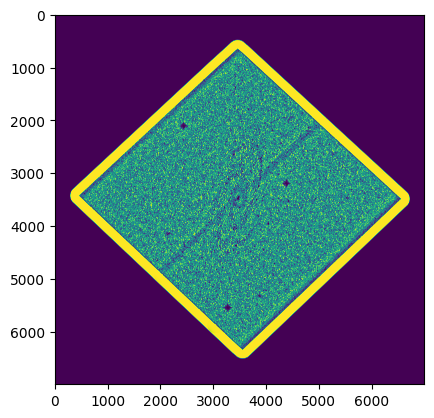

In [4]:
inputpath = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\CDD\ngc2090_F555W_HST_Extinction_CDDss0016pc.fits"
pixscale = .05
distance_Mpc = 12.3
scalepxval = pixscale * 4.848 * distance_Mpc  #convert to parcecs per pixel

with fits.open(inputpath) as hdu:
    hdu.info()
    img =hdu[0].data
    imagecopy=img.copy()
    image=np.nan_to_num(imagecopy)
    imageheader=hdu[0].header
    maskfoot=(image!=image[0,0])

n = 2
scale = 65535/n

imagemax=np.max(image)
imagemin=np.min(image)
image= scale-((image-imagemin)*scale/(imagemax-imagemin))
image[image> scale]= scale
image[image<0.]=0.
image=image.astype('uint16')

# Equalization
# scale increase/decrease doesn't change run time
radius =  int(5*16) * 2 + 1 #Make box 2% of smaller image dimension...appears to work well
#make the radius 2 * extracted_scale
footprint = disk(radius)  # disk of radius for local hist.eq

img_eq = rank.equalize(image, footprint, mask=maskfoot)

# img_eq[image < min_val] = 0

plt.imshow(img_eq)
plt.show()
outhdu = fits.PrimaryHDU(data=img_eq)
out_path = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\BkgSubDivRMS\HistEq_ngc2090.fits"

outhdu.writeto(out_path ,overwrite=True)

In [4]:
# import numpy as np
# import cv2
# from numpy.lib.stride_tricks import sliding_window_view
# import numpy as np
# import cv2
# from numpy.lib.stride_tricks import sliding_window_view
# from scipy.stats import ttest_ind
# import matplotlib.pyplot as plt

# def detect_and_remove_salt_pepper_noise(img, kernel_size=3):
#     """
#     Detects salt-and-pepper noise in an image and removes it by setting noisy pixels to zero.
    
#     Parameters:
#         image (numpy.ndarray): Input grayscale image.
#         kernel_size (int): Size of the median filter kernel (should be an odd number).
    
#     Returns:
#         numpy.ndarray: Image with detected noise regions set to zero.
#     """

#     image = img.copy()
#     # Apply median filter
#     median_filtered = cv2.medianBlur(image, kernel_size)
    
#     # Compute 10x10 patch sums and find regions where the difference exceeds sqrt(2) factor
#     patch_size = 50
#     noise_mask = np.zeros_like(image, dtype=bool)

#     # Use sliding window to extract patches from the image and median-filtered image
#     patches = sliding_window_view(image, (patch_size, patch_size))
#     filtered_patches = sliding_window_view(median_filtered, (patch_size, patch_size))

#     # Iterate over the sliding window patches (without explicit loops)
#     orig_patch_sums = patches.sum(axis=(2, 3))  # Sum across each patch
#     filtered_patch_sums = filtered_patches.sum(axis=(2, 3))  # Sum across each filtered patch

#     # Calculate noise mask based on the condition
#     mask_condition = np.abs(orig_patch_sums - filtered_patch_sums) >= np.sqrt(2) * filtered_patch_sums

#     # Create a noise mask based on the condition
#     noise_mask[:orig_patch_sums.shape[0], :orig_patch_sums.shape[1]] = mask_condition

#     # Create a copy of the image and set noisy patches to zero
#     denoised_image = img.copy()
#     denoised_image[noise_mask] = 0
    
#     return denoised_image

# # Assuming you have img_eq as your input image
# denoised_image = detect_and_remove_salt_pepper_noise(img_eq)

# # Plot the before and after images side by side
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# # Display original image
# ax[0].imshow(image, cmap='gray')
# ax[0].set_title('Original Image')
# ax[0].axis('off')

# # Display denoised image
# ax[1].imshow(denoised_image, cmap='gray')
# ax[1].set_title('Denoised Image')
# ax[1].axis('off')

# plt.tight_layout()
# plt.show()


In [5]:

# classified_image = isodata_classification(denoised_image, parameters={'K': 2})

# cluster_brightness = []
    
# for i in range(2):

#     # Get all the pixels in the current cluster
#     cluster_pixels = denoised_image[classified_image == i]
    
#     # Calculate the average intensity of the cluster (mean of all pixels in the cluster)
#     # Assuming grayscale, you can use np.mean. For color images, take the mean over channels
#     avg_intensity = np.mean(cluster_pixels)
#     cluster_brightness.append(avg_intensity)

# # Find the index of the brighter cluster
# brighter_cluster = np.argmax(cluster_brightness)
# darker_cluster = np.argmin(cluster_brightness)

# # Set all pixels in the darker cluster to zero in a copy of the original image
# img_class_zeroed = denoised_image.copy()
# img_class_zeroed[classified_image == darker_cluster] = 0

# # Plot the original and classified images side by side
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# # Display original image
# ax[0].imshow(img_eq, cmap='gray')


# ax[0].set_title('Original Image')
# ax[0].axis('off')

# # Display classified image
# ax[1].imshow(classified_image, cmap='gray')
# ax[1].set_title('Bright Region Retained')
# ax[1].axis('off')

# plt.tight_layout()
# plt.show()

Filename: C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\CDD\ngc2090_F555W_HST_Extinction_CDDss0016pc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     956   (7000, 7000)   int16 (rescales to uint16)   


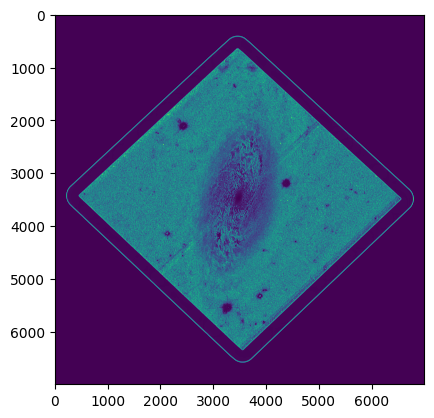

In [6]:
inputpath = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\CDD\ngc2090_F555W_HST_Extinction_CDDss0016pc.fits"

with fits.open(inputpath) as hdu:
    hdu.info()
    img =hdu[0].data

flatten_percent = 99

image = copy.deepcopy(img)
# Make flattened image
if flatten_percent is None:
    # Fit to a log-normal distribution
    fit_vals = lognorm.fit(image[~np.isnan(image)])  # Fit only non-NaN values
    median = lognorm.median(*fit_vals)
    std = lognorm.std(*fit_vals)
    thresh_val = median + 2 * std
else:
    # Use the specified percentile to calculate threshold
    thresh_val = np.percentile(image[~np.isnan(image)], flatten_percent)

# Apply the arctan transform, ensuring that we are dividing by the threshold value
flat_img = thresh_val * np.arctan(image / thresh_val)
plt.imshow(flat_img)
plt.show()

outhdu = fits.PrimaryHDU(data=flat_img)
out_path = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\BkgSubDivRMS\HistEq_8pc_ngc2090_flattened.fits"

outhdu.writeto(out_path ,overwrite=True)

Filename: c:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\OriginalImages\ngc2090_F555W_HST_Extinction.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     951   (7000, 7000)   float32   
  1  HDRTAB        1 BinTableHDU    559   6R x 275C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, 11A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, 8A, 23A, D, D, D, D, K, K, 8A, 23A, 9A, 19A, 4A, K, D, D, D, K, K, K, K, 23A, D, D, D, D, K, K, 4A, 3A, 4A, L, D, D, D, 23A, 1A, K, D, D, D, 4A, 1A, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 4A, 3A, 3A, 4A, 8A, 7A, D, K, D, 6A, 9A, 8A, D, D, 4A, 18A, 3A, K, 5A, 3A, D, 10A, 8A, 8A, 23A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, L, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, K, K, K, K, D, 3A, K, D, 5A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 12A, D, 24A, 23A, D, 1A, 1A, D, K, D, D, 1A, 1A, D, D, D, D, D, D, D, D, D, D, D, 4A, D, K, 23A, D,

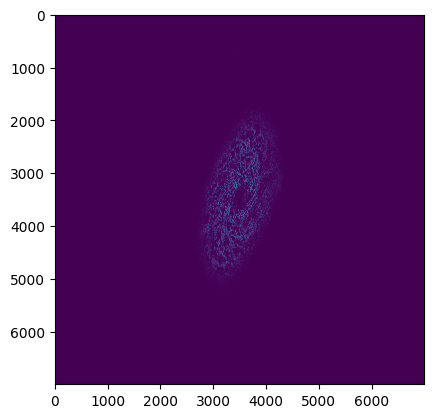

In [9]:
noise_min = 10**-2  


threshold = 10**-20 #pixels below this value will be seeds for mask

data_to_mask = flat_img

mask_copy = copy.deepcopy(data_to_mask)

#Dilate White Pixels
mask_copy[mask_copy > threshold] = 255
mask_copy = mask_copy.astype(np.uint8)
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.dilate(mask_copy, kernel, iterations= 5) 

#threshold other way
copy_image = copy.deepcopy(data_to_mask).astype(np.float32)
copy_image[dilated_image < threshold] = np.nan
mask = np.isnan(copy_image)

#set up binary mask
binary_mask = np.zeros_like(copy_image, dtype=np.uint8)
binary_mask[mask] = 255
binary_mask[~mask] = 0

#dilate the mask
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

dilated_image = copy.deepcopy(data_to_mask).astype(np.float32)
dilated_image[dilated_mask==255] = np.nan

#make a mask based on dilated image, true value indicates pixel should be masked
mask = np.isnan(dilated_image)

try:
    data = copy.copy(flat_img) 
    data = data.astype(np.float64) #photutils should take float64

    #subtract bkg
    bkg_estimator = MedianBackground()


    box_size = int(.01*np.min((np.shape(data)[0], np.shape(data)[1]))) * 2 + 1 #Make box 2% of smaller image dimension...appears to work well

    bkg = Background2D(data, box_size=box_size, coverage_mask = mask, exclude_percentile = 10, filter_size=(3,3), bkg_estimator=bkg_estimator) #Very different RMS with mask. Minimum noise is MUCH larger. 

    data -= bkg.background #subtract bkg

    data[data < 0] = 0 #Elimate neg values sinc this is over estimating the background. 

    noise = bkg.background_rms #bkg sub/RMS map

    noise[noise < noise_min] = noise_min #replace unphysical and absent noise with 10^-3 just to avoid division by zero

    divRMS = data/noise

    divRMS[(mask == 1)] = 0 #masked regions are zero

except ValueError:
    print("Error: Majrity Black pixels, cannot use photutils to enhance image")

inputpath = r"c:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\OriginalImages\ngc2090_F555W_HST_Extinction.fits"
with fits.open(inputpath) as hdu:
    hdu.info()
    img=hdu[0].data


divRMS[img < .1] = 0

outhdu = fits.PrimaryHDU(data=divRMS)
out_path = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\BkgSubDivRMS\HistEq_8pc_ngc2090_BkgSubDivRMS_cut.fits"

outhdu.writeto(out_path ,overwrite=True)

plt.imshow(divRMS)
plt.show()


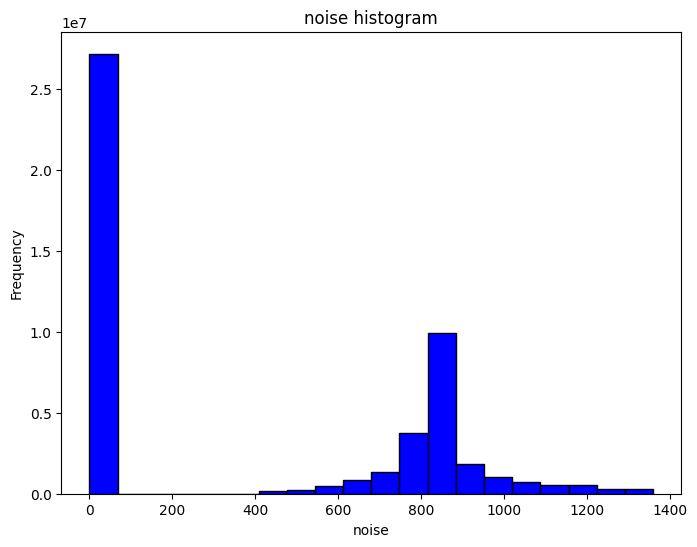

In [8]:
noise = noise[noise != 0]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(noise, bins=20, color='blue', edgecolor='black')
plt.title(f'noise histogram')
plt.xlabel('noise')
plt.ylabel('Frequency')
plt.show()


Filename: C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\BkgSubDivRMS\ngc2090_F555W_HST_Extinction_CDDss0016pc_BkgSubDivRMS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     954   (7000, 7000)   float64   


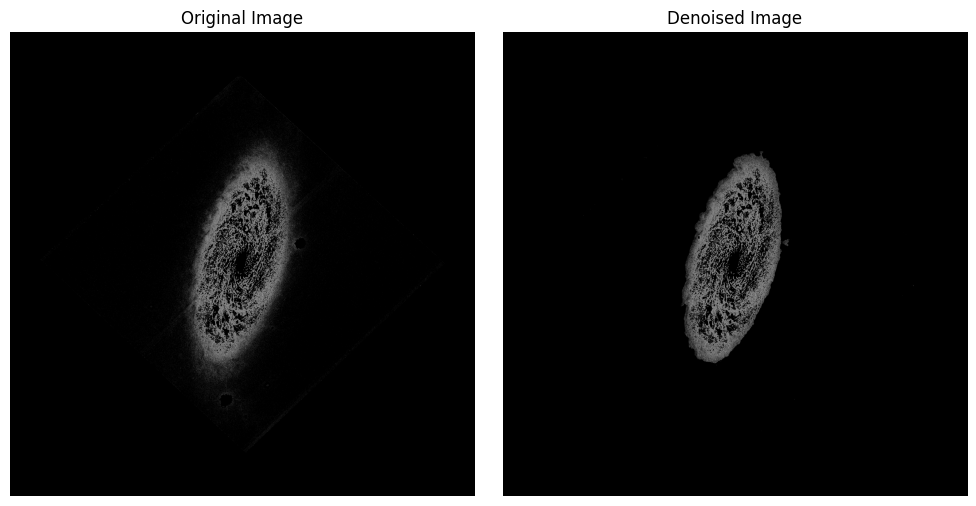

In [8]:
inputpath = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc2090_F555W\BkgSubDivRMS\ngc2090_F555W_HST_Extinction_CDDss0016pc_BkgSubDivRMS.fits"
import numpy as np
import cv2
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np
import cv2
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt



def detect_and_remove_salt_pepper_noise(img, kernel_size=3, patch_size = 50):
    """
    Detects salt-and-pepper noise in an image and removes it by setting noisy pixels to zero.
    
    Parameters:
        image (numpy.ndarray): Input grayscale image.
        kernel_size (int): Size of the median filter kernel (should be an odd number).
    
    Returns:
        numpy.ndarray: Image with detected noise regions set to zero.
    """

    image = img.copy()
    # Apply median filter
    median_filtered = cv2.medianBlur(image, kernel_size)
    
    # Compute 10x10 patch sums and find regions where the difference exceeds sqrt(2) factor
    noise_mask = np.zeros_like(image, dtype=bool)

    # Use sliding window to extract patches from the image and median-filtered image
    patches = sliding_window_view(image, (patch_size, patch_size))
    filtered_patches = sliding_window_view(median_filtered, (patch_size, patch_size))

    # Iterate over the sliding window patches (without explicit loops)
    orig_patch_sums = patches.sum(axis=(2, 3))  # Sum across each patch
    filtered_patch_sums = filtered_patches.sum(axis=(2, 3))  # Sum across each filtered patch

    # Calculate noise mask based on the condition
    mask_condition = np.abs(orig_patch_sums - filtered_patch_sums) >= np.sqrt(2) * filtered_patch_sums

    # Create a noise mask based on the condition
    noise_mask[:orig_patch_sums.shape[0], :orig_patch_sums.shape[1]] = mask_condition

    # Create a copy of the image and set noisy patches to zero
    denoised_image = img.copy()
    denoised_image[noise_mask] = 0
    
    return denoised_image

with fits.open(inputpath) as hdu:
    hdu.info()
    img =hdu[0].data

img = img.astype(np.uint8)


# Assuming you have img_eq as your input image
denoised_image = detect_and_remove_salt_pepper_noise(img, kernel_size = 3, patch_size = 50)

# Plot the before and after images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display original image
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display denoised image
ax[1].imshow(denoised_image, cmap='gray')
ax[1].set_title('Denoised Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()
